Unwanted stuff needed to run cv2 in python3

In [50]:
class Vec2D(object):
    def __init__(self, x=None, y=None):
        self.x = x
        self.y = y

class BoundingBox(object):
    def __init__(self):
        self.nonzero_rows = None
        self.nonzero_cols = None
        self.min_coords = Vec2D()
        self.max_coords = Vec2D()

def get_bb_from_mask(segmentation_mask: np.array) -> BoundingBox:
    '''Returns a BoundingBox object with information extracted
    from the given segmentation mask.

    Keyword arguments:
    segmentation_mask: np.array -- a 2D numpy array representing a grayscale image
                                   with a single object in it, where the assumption
                                   is that non-zero pixels represent the object

    '''
    bb = BoundingBox()
    bb.nonzero_rows, bb.nonzero_cols  = np.where(segmentation_mask)
    bb.min_coords.x, bb.max_coords.x = (np.min(bb.nonzero_cols), np.max(bb.nonzero_cols))
    bb.min_coords.y, bb.max_coords.y = (np.min(bb.nonzero_rows), np.max(bb.nonzero_rows))
    return bb

def get_bb(coords):
    bb = BoundingBox()
    bb.min_coords.x, bb.max_coords.x = (np.min(coords[0]), np.max(coords[0]))
    bb.min_coords.y, bb.max_coords.y = (np.min(coords[1]), np.max(coords[1]))
    return bb

def generate_transformation(bb: BoundingBox, boundaries: tuple) -> np.array:
    '''Generates a homogeneous transformation matrix of type int that translates,
    rotates, and scales the given bounding box, ensuring that the
    transformed points are within the given boundaries.

    Keyword arguments:
    bb: BoundingBox -- a BoundingBox object
    boundaries: tuple -- coordinate boundaries; assumed to represent
                         the (row, column) sizes of an image

    '''
    use_transformation = False
    t = None
    while not use_transformation:
        use_transformation = True
        rectangle_points = np.array([[bb.min_coords.x, bb.min_coords.x, bb.max_coords.x, bb.max_coords.x],
                                     [bb.min_coords.y, bb.max_coords.y, bb.min_coords.y, bb.max_coords.y]])
        rectangle_points = np.vstack((rectangle_points, [1., 1., 1., 1.]))

        # we generate a random rotation angle
        random_rot_angle = np.random.uniform(0, 2*np.pi)
        random_rot_matrix = np.array([[np.cos(random_rot_angle), -np.sin(random_rot_angle)],
                                      [np.sin(random_rot_angle), np.cos(random_rot_angle)]])

        # we generate a random translation within the image boundaries
        random_translation_x = np.random.uniform(-bb.min_coords.x, boundaries[1]-bb.max_coords.x)
        random_translation_y = np.random.uniform(-bb.min_coords.y, boundaries[0]-bb.max_coords.y)
        translation_vector = np.array([[random_translation_x], [random_translation_y]])

        # we generate a random scaling factor between 0.5 and 1.5
        # of the original object size
        random_scaling_factor = np.random.uniform(0.5, 1.0)
        s = np.array([[random_scaling_factor, 0., 0.],
                      [0., random_scaling_factor, 0.],
                      [0., 0., 1.]])

        t = np.hstack((random_rot_matrix, translation_vector))
        t = np.vstack((t, np.array([0., 0., 1.])))
        t = t.dot(s)

        transformed_bb = t.dot(rectangle_points)
        transformed_bb = np.array(transformed_bb, dtype=int)
        for point in transformed_bb.T:
            if point[0] < 0 or point[0] >= boundaries[1] or \
               point[1] < 0 or point[1] >= boundaries[0]:
                use_transformation = False
                break
    return t

In [86]:
# background_image_name = "background_1_light_14/background_0.jpg"
image_path = "robocup_images/objects_top_down/tableware/white_bowl/white_bowl_0.jpg"
segmentation_mask_path = "robocup_images/objects_top_down/tableware/white_bowl/object_masks/white_bowl_0_mask.jpg"



# background_img = np.array(background_image_name, dtype=np.uint8)
img = np.array(imread(image_path), dtype=np.uint8)
segmentation_mask = np.array(imread(segmentation_mask_path), dtype=np.uint8)

# noise removal
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(segmentation_mask,cv2.MORPH_OPEN,kernel, iterations = 15)


# cv2.imshow('Features', opening)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

# # sure background area
# sure_bg = cv2.dilate(opening,kernel,iterations=3)

# cv2.imshow('Features', sure_bg)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

# # Finding sure foreground area
# dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
# ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)

# # Finding unknown region
# sure_fg = np.uint8(sure_fg)
# unknown = cv2.subtract(sure_bg,sure_fg)

# cv2.imshow('Features', sure_fg)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

bb = get_bb_from_mask(opening)

xmin = bb.min_coords.x
xmax = bb.max_coords.x
ymin = bb.min_coords.y
ymax = bb.max_coords.y

cv2.rectangle(segmentation_mask,(xmin,ymin),(xmax,ymax),(255,0,0),2)
cv2.imshow('Features', segmentation_mask)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [1]:
import sys
sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')
# sys.path.remove('/home/kramer/Documents/ROS/catkin_ws/devel/lib/python2.7/dist-packages')

ValueError: list.remove(x): x not in list

### Background substraction

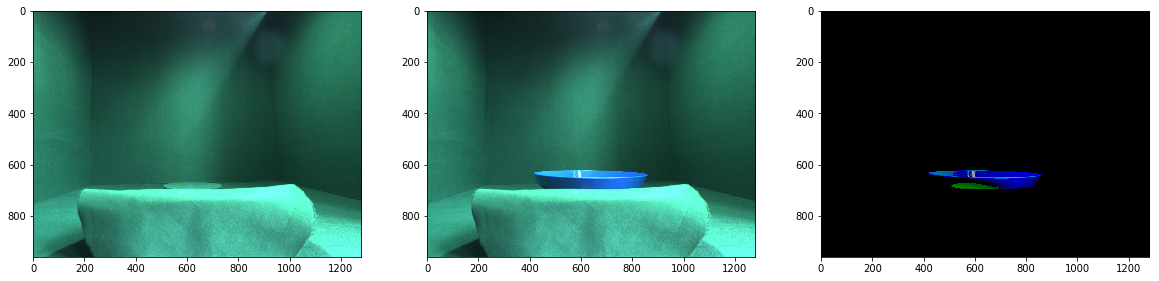

In [38]:
from imageio import imread, imwrite
import numpy as np
import matplotlib.pyplot as plt

threshold = 80

img = np.array(imread("robocup_images/objects_front/tableware/blue_plate/blue_plate_0.jpg"), dtype=int)
# img = np.array(imread("robocup_images/objects_front/cereal/chockn_roll/chockn_roll_0.jpg"), dtype=int)
background = np.array(imread("background_1_light_14/background_0.jpg"), dtype=int)
img_diff = np.clip(np.abs(img - background), 0, 255)
img_diff = np.array(img_diff, dtype=np.uint8)

small_brightness_pixels = np.where(img_diff < threshold)
img_diff[small_brightness_pixels] = 0

# high_brightness_pixels = np.where(img_diff > threshold)
# img_diff[high_brightness_pixels] = 255


fig = plt.figure(1, (20,8))
fig.add_subplot(1, 3, 1)
plt.imshow(background)
fig.add_subplot(1, 3, 2)
plt.imshow(img)
fig.add_subplot(1, 3, 3)
plt.imshow(img_diff)

plt.show()

### Convert mask to grayscale

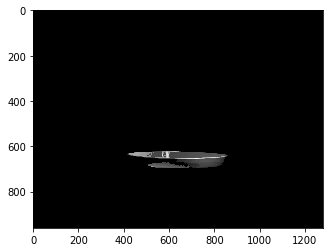

In [39]:
import cv2
im2 = cv2.cvtColor(img_diff,cv2.COLOR_BGR2GRAY)
plt.imshow(im2, cmap='gray')
plt.show()

### Generate bounding box using mask

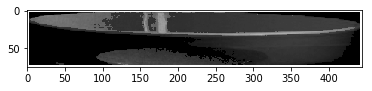

In [41]:
nonzero_rows, nonzero_cols = np.where(im2)
min_i, max_i = (np.min(nonzero_rows), np.max(nonzero_rows))
min_j, max_j = (np.min(nonzero_cols), np.max(nonzero_cols))
# indices = np.meshgrid(np.arange(np.min(i), np.max(i) + 1),
#                       np.arange(np.min(j), np.max(j) + 1),
#                       indexing='ij')
plt.imshow(im2[min_i:max_i, min_j:max_j], cmap='gray')
plt.show()

cv2.rectangle(im2,(min_j,min_i),(max_j,max_i),(255,255,255),2)
cv2.imshow('Features', im2)
cv2.waitKey(0)
cv2.destroyAllWindows()

### Locate mask with bounding in artificial image

In [20]:
nonzero_rows, nonzero_cols = np.where(im2)
min_i, max_i = (np.min(nonzero_rows), np.max(nonzero_rows))
min_j, max_j = (np.min(nonzero_cols), np.max(nonzero_cols))

back_image = imread('robocup_images/augmentation_backgrounds/apartment.jpg')
# obj_rectangle = np.where(im2[min_i:max_i, min_j:max_j] > 0)

# back_image[i, j] = img[i, j]
# plt.figure(figsize=(20,10))
# plt.imshow(back_image)
# plt.show()
# cv2.rectangle(back_image,(min_j,min_i),(max_j,max_i),(255,255,255),2)
# cv2.imshow('Features', back_image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [10]:
import pandas as pd
import cv2
from imageio import imread, imwrite
import numpy as np
df_train = pd.read_csv('coords_train.csv', sep=',')
df_val = pd.read_csv('coords_val.csv', sep=',')

In [10]:
import cv2
import yaml 
import os 

# img = cv2.imread('robocup_images/training_images/sponge_top_05_04_19_18_308.jpg')
# img_name = 'validation_images/sponge_top_05_04_19_18_308.jpg'
with open('robocup_images/train_annotations.yml', 'r') as annotations_f:
    annotations = yaml.load(annotations_f, Loader=yaml.FullLoader)
folder = 'robocup_images'
for img_dict in annotations:
#     if img_dict['image_name'] == img_name:
    img_name = img_dict['image_name']
    img_path = os.path.join(folder,img_name)
    img = cv2.imread(img_path)
    objects = img_dict['objects']
    for object_ in objects:
        xmin = object_['xmin']
        xmax = object_['xmax']
        ymin = object_['ymin']
        ymax = object_['ymax']
        cv2.rectangle(img,(xmin,ymin),(xmax,ymax),(255,0,0),2)
    cv2.imshow('Features', img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

KeyboardInterrupt: 

## Validate images in training and validation files

In [38]:
print('===========================================================')
print('Validating training files ')
print('===========================================================')
for img_idx in range(0, df_train.shape[0]):
    img_name = df_train.iloc[image_idx,0]
    try:
        img = cv2.imread(img_name)
    except:
        print('Corrupted file ', img_name)
        
print('===========================================================')
print('Validating validation files ')
print('===========================================================')   
for img_idx in range(0, df_val.shape[0]):
    img_name = df_val.iloc[image_idx,0]
    img = cv2.imread(img_name)
    try:
        img = cv2.imread(img_name)
    except:
        print('Corrupted file ', img_name)

Validating training files 
Validating validation files 


In [52]:
image_idx = np.random.randint(0,df_val.shape[0])
print(image_idx)
img_name = df_val.iloc[image_idx,0]
img = cv2.imread(img_name)
xmin = df_val.iloc[image_idx,1]
xmax = df_val.iloc[image_idx,2]
ymin = df_val.iloc[image_idx,3]
ymax = df_val.iloc[image_idx,4]

cv2.rectangle(img,(xmin,ymin),(xmax,ymax),(255,0,0),2)
cv2.imshow('Features', img)
cv2.waitKey(0)
cv2.destroyAllWindows()

512


In [ ]:
print(df)
img = df.iloc[0,0]
img = imread(img)
xmin = df.iloc[0,1]
xmax = df.iloc[0,2]
ymin = df.iloc[0,3]
ymax = df.iloc[0,4]

# plt.figure(figsize=(20,10))
# plt.imshow(img)
# plt.show()
cv2.rectangle(img,(xmin,ymin),(xmax,ymax),(255,255,255),2)
cv2.imshow('Features', img)
cv2.waitKey(0)
cv2.destroyAllWindows()

### Generating artificial images:
* Translation
* Rotation
* Scaling?

In [ ]:
print(np.array([min_i, max_i]))
print(np.array([min_j, max_j]))
print(bb)

In [17]:
def generate_transformation(back_image, min_max_i, min_max_j):
    min_i, max_i = min_max_i
    min_j, max_j = min_max_j
    rectangle_points = np.array([[min_i, min_i, max_i, max_i],
                                 [min_j, max_j, min_j, max_j]])
    rectangle_points = np.vstack((rectangle_points, [1., 1., 1., 1.]))

    random_rot_angle = np.random.uniform(0, 2*np.pi)
    random_rot_matrix = np.array([[np.cos(random_rot_angle), -np.sin(random_rot_angle)],
                                  [np.sin(random_rot_angle), np.cos(random_rot_angle)]])
    random_translation_x = np.random.uniform(-min_i, back_image.shape[1]-max_i)
    random_translation_y = np.random.uniform(-min_j, back_image.shape[0]-max_j)
    translation_vector = np.array([[random_translation_x], [random_translation_y]])

    t = np.hstack((random_rot_matrix, translation_vector))
    t = np.vstack((t, np.array([0., 0., 1.])))

    transformed_bb = t.dot(rectangle_points)
    transformed_bb = np.array(transformed_bb, dtype=int)

    use_transformation = True
    for point in transformed_bb.T:
        if point[0] < 0 or point[0] > back_image.shape[0] or \
           point[1] < 0 or point[1] > back_image.shape[1]:
            use_transformation = False
            break
    return t, use_transformation

In [21]:
use_transformation = False
t = None
while not use_transformation:
    t, use_transformation = generate_transformation(back_image,
                                                    (min_i, max_i),
                                                    (min_j, max_j))

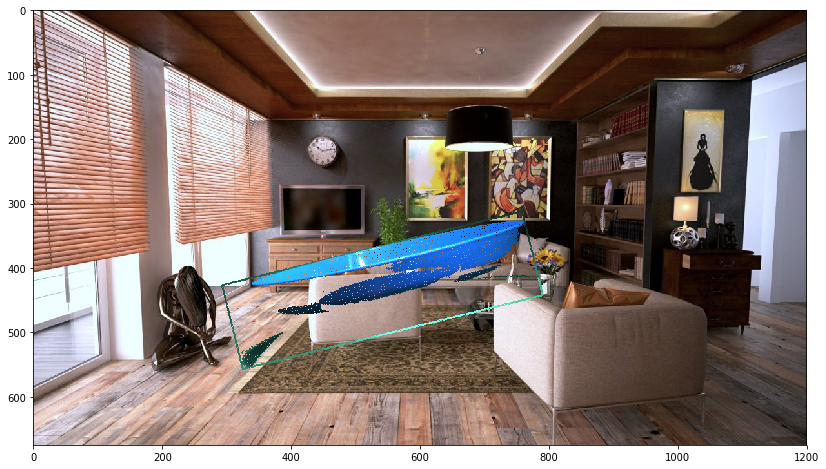

In [22]:
obj_coords = np.vstack((nonzero_rows[np.newaxis],
                        nonzero_cols[np.newaxis],
                        np.ones(len(nonzero_rows), dtype=int)))

# t = np.array([[np.cos(np.pi/4.), -np.sin(np.pi/4.), 200.], [np.sin(np.pi/4.), np.cos(np.pi/4.), 500.], [0., 0., 1.]])
transformed_obj_coords = t.dot(obj_coords)
transformed_obj_coords = np.array(transformed_obj_coords, dtype=int)

for i, point in enumerate(transformed_obj_coords.T):
    x = point[0]
    y = point[1]

    back_image[x, y] = img[obj_coords[0, i], obj_coords[1, i]]

fig = plt.figure(figsize=(20,8))
plt.imshow(back_image)
plt.show()